In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import importlib

# Add project root to path for imports (go up one level from validation folder)
PROJECT_ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import SeaEcho modules
from utils.SeaEcho_water import seawater  
from utils.SeaEcho_gas_bubble import air_bubble

# Reload the Medwin-Clay model to ensure we get the updated version
import Bubble.models.weston_medwin_model
importlib.reload(Bubble.models.weston_medwin_model)
from Bubble.models.weston_medwin_model import calculate_wm_ts
import Bubble.models.anderson_weston_model
importlib.reload(Bubble.models.anderson_weston_model)
from Bubble.models.anderson_weston_model import calculate_aw_ts
import Bubble.models.ainslie_leighton_model
importlib.reload(Bubble.models.ainslie_leighton_model)
from Bubble.models.ainslie_leighton_model import calculate_ainslie_leighton_ts

ImportError: cannot import name 'compute_viscous_damping' from 'model_specific_utils.ainslie_leighton_utils' (/Users/sbthp/Documents/EFDLab/seaEchoTSCalculator/Bubble/model_specific_utils/ainslie_leighton_utils.py)

In [ ]:
import numpy as np

# targets (paper-style)
eps0_target = 0.30          # ε0 = ω0 R0 / c
two_b_over_w0_target = 0.00 # Fig. 2 → 0.00 ; Fig. 5 → e.g. 0.30

# resonance “f0” used for axis (your models expect kHz)
f0_khz = 1000.0
omega0 = 2*np.pi*(f0_khz*1e3)

# environment
wtr = seawater(temperature=10.0, depth=100.0, salinity=35.0)
c = wtr.c

# set R0 from ε0, set β0 from target 2β0/ω0
R0 = eps0_target * c / omega0
diam = 2.0 * R0
beta0 = 0.5 * two_b_over_w0_target * omega0

# bubble object
bub = air_bubble(wtr, T=wtr.T, z=wtr.z, S=wtr.S, diameter=diam)

# expose damping to the models (if your model reads this, it will use it;
# if not, the call wrappers below also let you override via kwarg when available)
bub.beta0_override = beta0

# frequency axis (kHz) and a convenience Hz version
fk = np.linspace(0.7*f0_khz, 1.3*f0_khz, 6000)
w  = 2*np.pi*(fk*1e3)

# quick sanity: report the parameters actually used
eps0_actual = (omega0*R0)/c
two_b_over_w0_actual = 2*beta0/omega0
print(f"ε0 target/actual = {eps0_target:.3f} / {eps0_actual:.3f}")
print(f"2β0/ω0 target/actual = {two_b_over_w0_target:.3f} / {two_b_over_w0_actual:.3f}")


ε0 target/actual = 0.300 / 0.300
2β0/ω0 target/actual = 0.000 / 0.000


In [ ]:
import numpy as np

def ts_curve(model_fn, fk_khz, c, water, bubble):
    vfn = np.vectorize(lambda f: model_fn(f, c, water, bubble))
    return vfn(fk_khz)  # TS in dB

def sigma_norm_from_ts_db(ts_db, R0):
    return (10.0**(ts_db/10.0)) / (4.0*np.pi*R0**2)

def sigma_norm_eq43(fk_khz, R0, c, omega0, beta0):
    w = 2*np.pi*(fk_khz*1e3)
    eps = (w*R0)/c
    real = (omega0**2 / w**2) - 1.0 - 2.0*(beta0/w)*eps
    imag = 2.0*(beta0/w) + (omega0**2 / w**2)*eps
    den  = real**2 + imag**2
    return 1.0/den


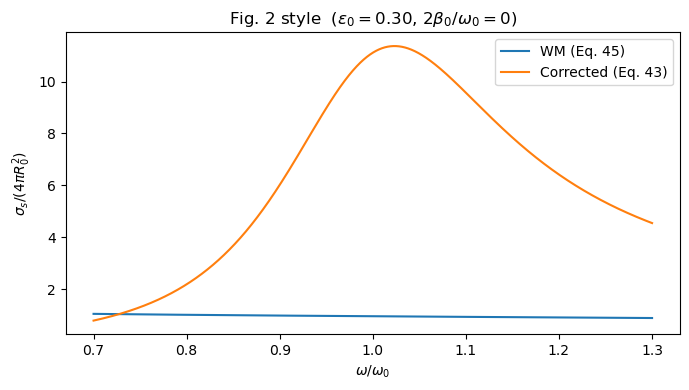

In [ ]:
import matplotlib.pyplot as plt

# temporarily force zero damping for Fig. 2
beta0_saved = beta0
bub.beta0_override = 0.0
beta0 = 0.0

wm_ts_db_fig2 = ts_curve(calculate_wm_ts, fk, c, wtr, bub)
wm_sig_fig2   = sigma_norm_from_ts_db(wm_ts_db_fig2, R0)
al_sig_fig2   = sigma_norm_eq43(fk, R0, c, omega0, beta0)

# restore damping
beta0 = beta0_saved
bub.beta0_override = beta0

plt.figure(figsize=(7,4))
plt.plot(fk/f0_khz, wm_sig_fig2, label="WM (Eq. 45)")
plt.plot(fk/f0_khz, al_sig_fig2, label="Corrected (Eq. 43)")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"$\sigma_s/(4\pi R_0^2)$")
plt.title(r"Fig. 2 style  ($\epsilon_0=0.30$, $2\beta_0/\omega_0=0$)")
plt.legend(); plt.tight_layout(); plt.show()


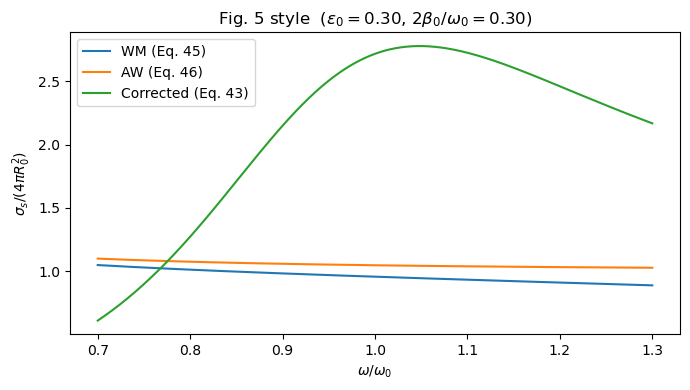

In [ ]:
# set a finite damping ratio for Fig. 5
two_b_over_w0_target = 0.30
beta0 = 0.5 * two_b_over_w0_target * omega0
bub.beta0_override = beta0

wm_ts_db = ts_curve(calculate_wm_ts, fk, c, wtr, bub)
aw_ts_db = ts_curve(calculate_aw_ts, fk, c, wtr, bub)

wm_sig = sigma_norm_from_ts_db(wm_ts_db, R0)
aw_sig = sigma_norm_from_ts_db(aw_ts_db, R0)
al_sig = sigma_norm_eq43(fk, R0, c, omega0, beta0)

plt.figure(figsize=(7,4))
plt.plot(fk/f0_khz, wm_sig, label="WM (Eq. 45)")
plt.plot(fk/f0_khz, aw_sig, label="AW (Eq. 46)")
plt.plot(fk/f0_khz, al_sig, label="Corrected (Eq. 43)")
plt.xlabel(r"$\omega/\omega_0$")
plt.ylabel(r"$\sigma_s/(4\pi R_0^2)$")
plt.title(rf"Fig. 5 style  ($\epsilon_0=0.30$, $2\beta_0/\omega_0={2*beta0/omega0:.2f}$)")
plt.legend(); plt.tight_layout(); plt.show()
